# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import graphviz
import pydot_ng as pydot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup
from math import floor


In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from math import sqrt 


In [6]:
def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 1

In [7]:
# Split data

train_dataframe = df[df['year']<= 2020] 
test_dataframe =  df[df['year']>2020]

In [8]:
train_dataframe.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [9]:
global train_dataframe
global test_dataframe

category_not_used = ["full_address", "nearest_stn"]
train_dataframe = train_dataframe.drop(category_not_used, axis = 1)
test_dataframe = test_dataframe.drop(category_not_used, axis = 1)

train_ds = dataframe_to_dataset(train_dataframe)
test_ds = dataframe_to_dataset(test_dataframe)

train_ds = train_ds.batch(256)
test_ds = test_ds.batch(256)

## Question 1A 
#### Why is this done instead of using random train/test split?

**The rationale to predict resale prices is to used past data as the training dataset to predict future values. Hence the training dataset are used for year <= 2020.**


## Question 1B 

In [10]:
global month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_years, degree_centrality, eigenvector_centrality, dist_to_nearest_stn, dist_to_dhoby
global all_inputs
global month_encoded, storey_range_encoded, flat_model_type_encoded, floor_area_sqm_encoded, remaining_lease_year_encoded, degree_centrality_encoded, eigenvector_centrality_encoded, dist_to_nearest_stn_encoded, dist_to_dhoby_encoded

In [11]:
#Categorical feature encoded as integer
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorical feature encoded as string
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical features
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
#resale_price = keras.Input(shape=(1,), name="resale_price")

all_inputs = [month,flat_model_type,storey_range,dist_to_nearest_stn,
            dist_to_dhoby,degree_centrality,eigenvector_centrality,remaining_lease_years,floor_area_sqm]


#Integer categorical features
month_encoded = encode_categorical_feature(month, "month",train_ds, False)

#String categorical features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range",train_ds, True)

#Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)

all_features = layers.Concatenate()(
                [
                    month_encoded,
                    storey_range_encoded,
                    flat_model_type_encoded,
                    floor_area_sqm_encoded,
                    remaining_lease_year_encoded,
                    degree_centrality_encoded,
                    eigenvector_centrality_encoded,
                    dist_to_nearest_stn_encoded,
                    dist_to_dhoby_encoded
                ]
)
output = layers.Dense(1, activation="linear")(all_features)
adam_model = keras.Model(all_inputs, output)
adam_model.compile(optimizer="adam", loss= "mse",metrics=[r2])


#### **ARCHITECTURE**

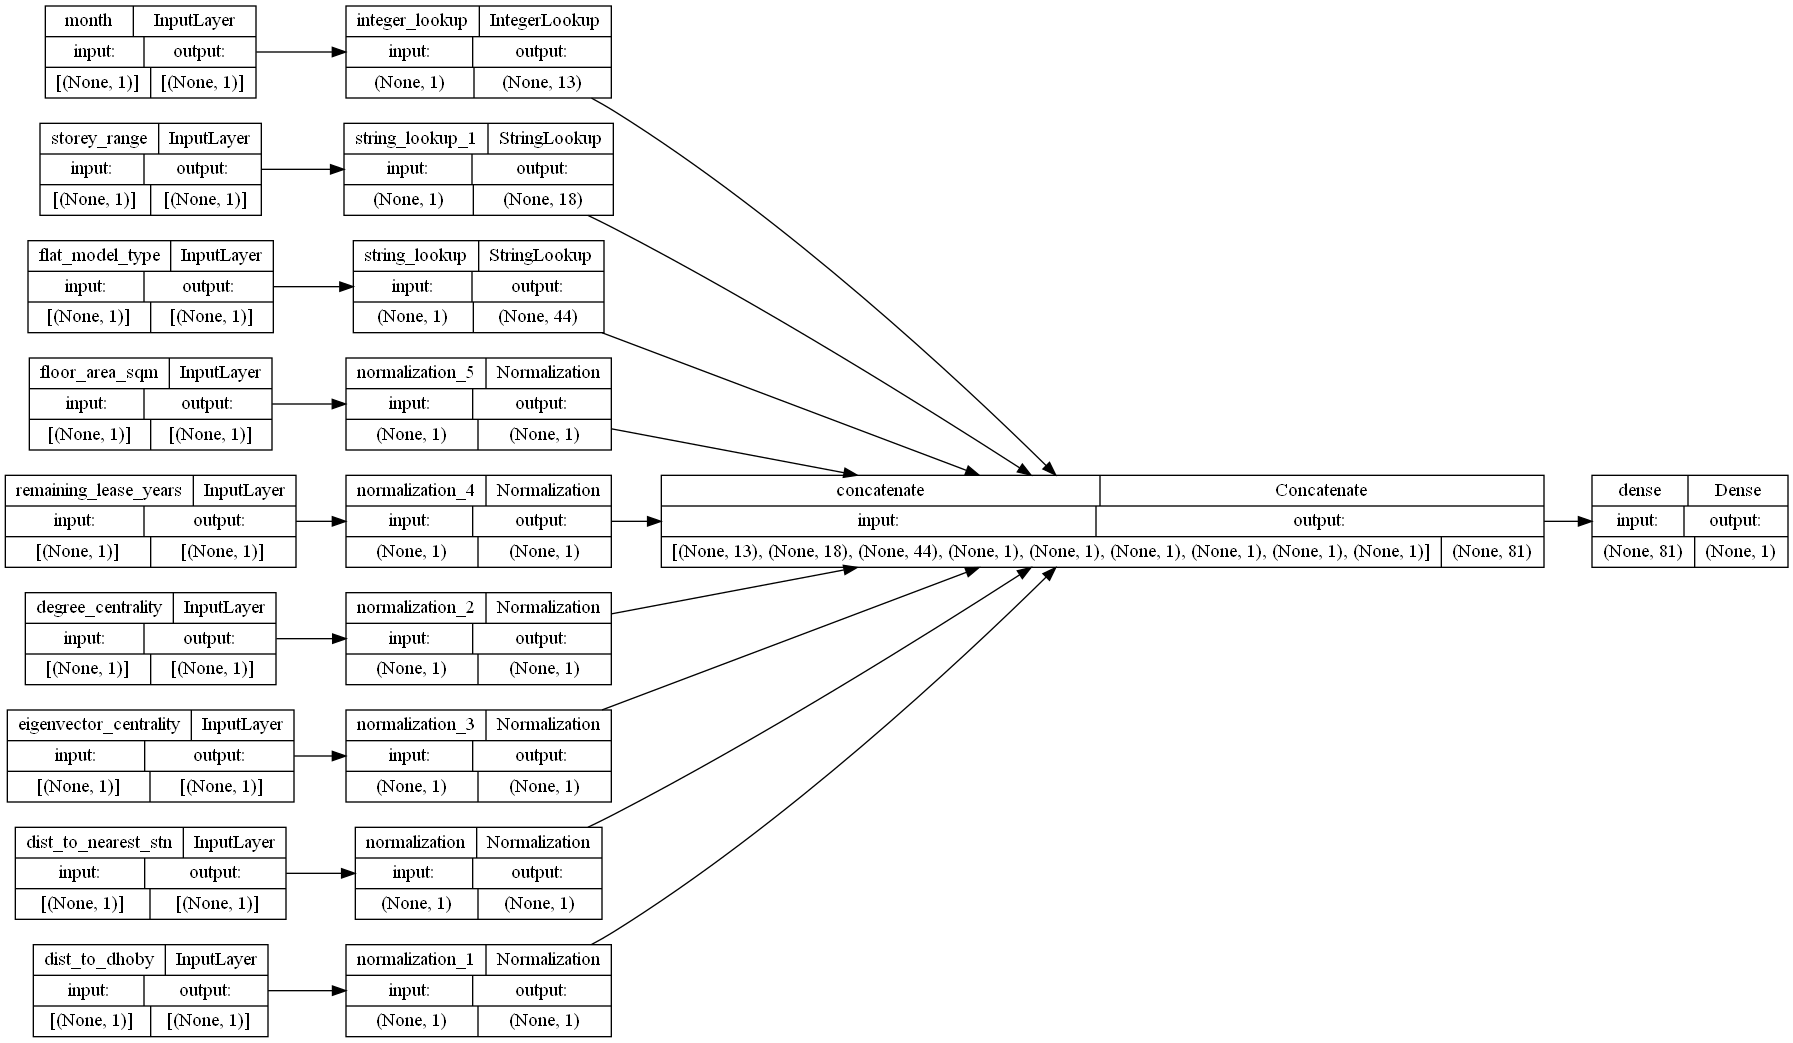

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(adam_model, show_shapes=True, rankdir="LR")

## Question 1C
#### Training **Adam** model and **SGD** model 

In [13]:
history = {}
no_epochs = 50
batch_size = 256
history["adam_model"] = adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 5s 9ms/step - loss: 219585921024.0000 - r2: -8.3474 - val_loss: 301486735360.0000 - val_r2: -10.0832
Epoch 2/50
342/342 [==============================] - 3s 8ms/step - loss: 219584561152.0000 - r2: -8.3520 - val_loss: 301485064192.0000 - val_r2: -10.0722
Epoch 3/50
342/342 [==============================] - 3s 8ms/step - loss: 219583217664.0000 - r2: -8.3501 - val_loss: 301483458560.0000 - val_r2: -10.1026
Epoch 4/50
342/342 [==============================] - 4s 10ms/step - loss: 219581890560.0000 - r2: -8.3437 - val_loss: 301481951232.0000 - val_r2: -10.0800
Epoch 5/50
342/342 [==============================] - 4s 9ms/step - loss: 219580661760.0000 - r2: -8.3458 - val_loss: 301480378368.0000 - val_r2: -10.1214
Epoch 6/50
342/342 [==============================] - 3s 9ms/step - loss: 219579383808.0000 - r2: -8.3513 - val_loss: 301478871040.0000 - val_r2: -10.0838
Epoch 7/50
342/342 [==============================] - 3s 8ms/step - loss: 219578

#### Training of **SGD model** with learning rate **0.01**

In [14]:
custom_optimizer=tf.keras.optimizers.SGD(learning_rate=0.01)
sgd_model = keras.Model(all_inputs, output)
sgd_model.compile(optimizer=custom_optimizer, loss="mse", metrics=[r2])
history["sgd_model"] = sgd_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50
342/342 [==============================] - 4s 9ms/step - loss: 18724683776.0000 - r2: 0.1967 - val_loss: 13789810688.0000 - val_r2: 0.4959
Epoch 2/50
342/342 [==============================] - 3s 8ms/step - loss: 5481840128.0000 - r2: 0.7678 - val_loss: 12796226560.0000 - val_r2: 0.5320
Epoch 3/50
342/342 [==============================] - 3s 8ms/step - loss: 5026614784.0000 - r2: 0.7875 - val_loss: 12325056512.0000 - val_r2: 0.5501
Epoch 4/50
342/342 [==============================] - 3s 8ms/step - loss: 4776948224.0000 - r2: 0.7976 - val_loss: 12102066176.0000 - val_r2: 0.5574
Epoch 5/50
342/342 [==============================] - 3s 8ms/step - loss: 4609028096.0000 - r2: 0.8049 - val_loss: 11926619136.0000 - val_r2: 0.5641
Epoch 6/50
342/342 [==============================] - 3s 8ms/step - loss: 4482668544.0000 - r2: 0.8106 - val_loss: 11662412800.0000 - val_r2: 0.5736
Epoch 7/50
342/342 [==============================] - 3s 8ms/step - loss: 4384758272.0000 - r2: 0.8140 - 

In [15]:
data = {"Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
       }
data_df = pd.DataFrame.from_dict(data)
data_df

,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,-8.350128,-10.07388,0.840261,0.610094


#### Report why the change to SGD fixes the problem faced when using Adam optimiser

**From the table above, we can see the difference in R^2 for both Adam and SGD optimiser.**

**Adam algorithm is leverages on the power of adaptive learning rates methods to find individual learning rates for each parameter. Due to the low learning rate of the Adam optimiser, it is very likely that it does not have sufficient iteration time to converge to minima and yield a decent R^2 value**

**SGD algorithm with a learning rate of 0.01 allows the model to generalize faster and converge faster to minima**

## Question 1D 
#### Training of **Adam** model with learning rate of **0.08**

In [16]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.08)
hidden_layer = layers.Dense(10, activation ="linear")(all_features)
Q1D_output = layers.Dense(1, activation="linear")(hidden_layer)
Q1D_adam_model = keras.Model(all_inputs, Q1D_output)
Q1D_adam_model.compile(optimizer=adam_optimizer, loss= "mse",metrics=[r2])

In [17]:
history["Q1D_adam_model"] = Q1D_adam_model.fit(train_ds, epochs=no_epochs,batch_size=batch_size, validation_data=test_ds, verbose=1)

Epoch 1/50


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


342/342 [==============================] - 4s 9ms/step - loss: 198604029952.0000 - r2: -7.4464 - val_loss: 226039087104.0000 - val_r2: -7.3163
Epoch 2/50
342/342 [==============================] - 3s 8ms/step - loss: 99525992448.0000 - r2: -3.2406 - val_loss: 88990220288.0000 - val_r2: -2.2731
Epoch 3/50
342/342 [==============================] - 3s 8ms/step - loss: 23373897728.0000 - r2: 0.0066 - val_loss: 25650939904.0000 - val_r2: 0.0618
Epoch 4/50
342/342 [==============================] - 3s 8ms/step - loss: 6420192768.0000 - r2: 0.7287 - val_loss: 14056211456.0000 - val_r2: 0.4869
Epoch 5/50
342/342 [==============================] - 3s 8ms/step - loss: 5106189312.0000 - r2: 0.7841 - val_loss: 12450712576.0000 - val_r2: 0.5452
Epoch 6/50
342/342 [==============================] - 3s 9ms/step - loss: 4765254656.0000 - r2: 0.7983 - val_loss: 11993393152.0000 - val_r2: 0.5622
Epoch 7/50
342/342 [==============================] - 3s 9ms/step - loss: 4506057216.0000 - r2: 0.8093 - val

## Question 1E 


In [18]:
# Compare with a table and explain
Q1_data = {"Q1D_Adam_Train R^2": [history["Q1D_adam_model"].history["r2"][-1]],
        "Q1D_Adam_Val R^2": [history["Q1D_adam_model"].history["val_r2"][-1]],
        "Q1C_Adam_Train R^2": [history["adam_model"].history["r2"][-1]],
        "Q1C_Adam_Val R^2": [history["adam_model"].history["val_r2"][-1]],
        "SGD_Train R^2": [history["sgd_model"].history["r2"][-1]],
        "SGD_Val R^2": [history["sgd_model"].history["val_r2"][-1]]
        }


data_df = pd.DataFrame.from_dict(Q1_data)
data_df

,Q1D_Adam_Train R^2,Q1D_Adam_Val R^2,Q1C_Adam_Train R^2,Q1C_Adam_Val R^2,SGD_Train R^2,SGD_Val R^2
0,0.845678,0.628727,-8.350128,-10.07388,0.840261,0.610094


#### Compare the performance of 1C and 1D to the linear regression model and suggest reasons for the observations

**From the table, the R^2 value from Q1D is higher than the linear regression model (0.627) and the R^2 value from Q1C is higher than the linear regression model(0.627).** 

**In Q1C, the SGD model do not have the complexity to discover and learn the relationships between the input features and thus leading to a poorer result compared to the linear regression model.**

**In 1D, there is an additional hidden layer and a rise in learning rate for the Adam optimiser.Thus, performance of the network model will be better as with the hidden layer, the neural network will then be able to learn complex tasks as the network model can capture more complexity and discover relationships between the features in the input.**

**Also, with the higher learning rate, the modified adam optimiser will converge faster.**

## Question 2

## Question 2A

#### Further split of training dataset to train and validation

In [19]:
Q2_validation_dataframe = train_dataframe[train_dataframe["year"]==2020]
Q2_train_dataframe = train_dataframe[train_dataframe["year"]<2020]


In [20]:
Q2_train_ds = dataframe_to_dataset(Q2_train_dataframe)
Q2_val_ds = dataframe_to_dataset(Q2_validation_dataframe)

Q2_train_ds = Q2_train_ds.batch(256)
Q2_val_ds = Q2_val_ds.batch(256)

## Question 2B

In [21]:
def Q2_encode_categorical_feature(feature, name, dataset, is_string, num_categories, divisor):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x,-1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)

    emb = layers.Embedding(input_dim=num_categories+1, output_dim=floor(num_categories//divisor))
    embedded = emb(encoded_feature)

    return layers.Flatten()(embedded)


## Question 2C

In [22]:
global callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [23]:
# Numerical features
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", Q2_train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", Q2_train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", Q2_train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", Q2_train_ds)
remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", Q2_train_ds)
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", Q2_train_ds)

In [24]:
import keras_tuner

def build_model(hp):    
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)

    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    

    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",Q2_train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",Q2_train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",Q2_train_ds, True, storey_range_num_categories, divisor)
    
    Q2_all_features = layers.Concatenate()(
                    [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
        )
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(Q2_all_features)
    Q2_output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2_model = keras.Model(all_inputs, Q2_output)
    Q2_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])

    return Q2_model
    


In [25]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

tuner.search(Q2_train_ds, epochs=50, validation_data=Q2_val_ds, callbacks=[callback])
best_model = tuner.get_best_models(1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]

Trial 10 Complete [00h 02m 20s]
val_loss: 206168031232.0

Best val_loss So Far: 3852310272.0
Total elapsed time: 00h 21m 39s
INFO:tensorflow:Oracle triggered exit


#### Best hyperparamters 

In [26]:
best_hyperparameters.values

{'learning_rate': 0.07341006871139777, 'divisor': 2, 'hidden_units': 12}

## Question 2D 
**Training of model based on best model configuration and test RMSE** 

In [27]:
Q2_best_model_history = {}
Q2_best_model = build_model(best_hyperparameters)

# Save best epoch only
callback_list = [
       tf.keras.callbacks.ModelCheckpoint(
            filepath='PartB_bestepoch/', 
            save_freq='epoch', verbose=1, monitor='val_loss', 
            save_weights_only=True, save_best_only=True
       )         
]

# Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
Q2_best_model_history["best_model"] = Q2_best_model.fit(train_ds, epochs=50, validation_data = test_ds, verbose=1, callbacks=callback_list)

Epoch 1/50
336/342 [============================>.] - ETA: 0s - loss: 54468304896.0000 - r2: -1.2886
Epoch 1: val_loss improved from inf to 15283115008.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 4s 10ms/step - loss: 53748383744.0000 - r2: -1.2546 - val_loss: 15283115008.0000 - val_r2: 0.4427
Epoch 2/50
339/342 [============================>.] - ETA: 0s - loss: 7772963840.0000 - r2: 0.6711
Epoch 2: val_loss improved from 15283115008.00000 to 13925519360.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 4s 10ms/step - loss: 7767461888.0000 - r2: 0.6715 - val_loss: 13925519360.0000 - val_r2: 0.4905
Epoch 3/50
339/342 [============================>.] - ETA: 0s - loss: 6795694080.0000 - r2: 0.7115
Epoch 3: val_loss improved from 13925519360.00000 to 12766651392.00000, saving model to PartB_bestepoch\
342/342 [==============================] - 3s 9ms/step - loss: 6796286976.0000 - r2: 0.7116 - val_loss: 12766651392.0000

In [28]:
def square_roots(l):
    result = [sqrt(i) for i in l]
    return result

#### Plot of Train & Test RMSE for 50 epochs

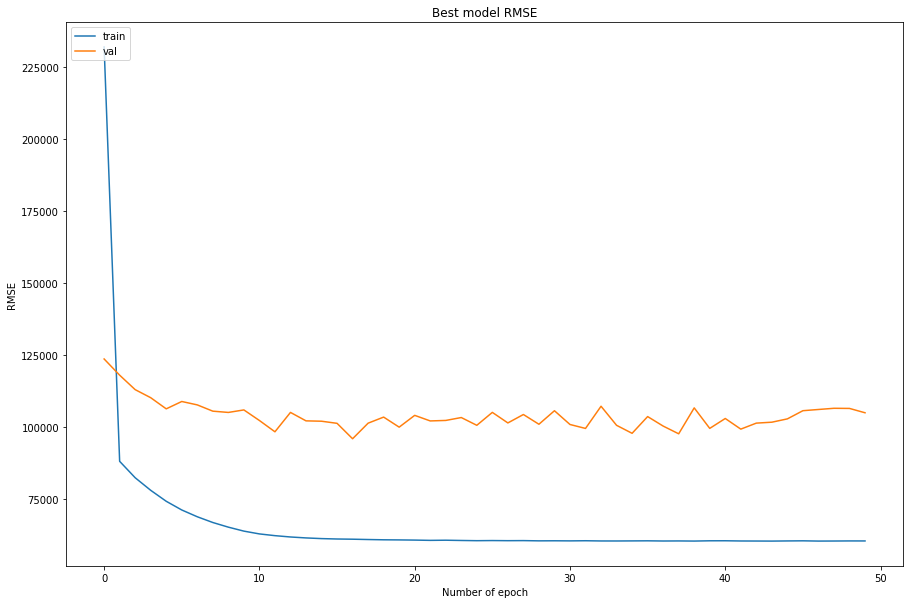

In [29]:
import matplotlib.pyplot as plt
plt_1 = plt.figure(figsize=(15, 10))
# Plot 
plt.plot(square_roots(Q2_best_model_history['best_model'].history['loss']))
plt.plot(square_roots(Q2_best_model_history['best_model'].history['val_loss']))
plt.title('Best model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Plot of Train & Test R^2 for 50 epochs

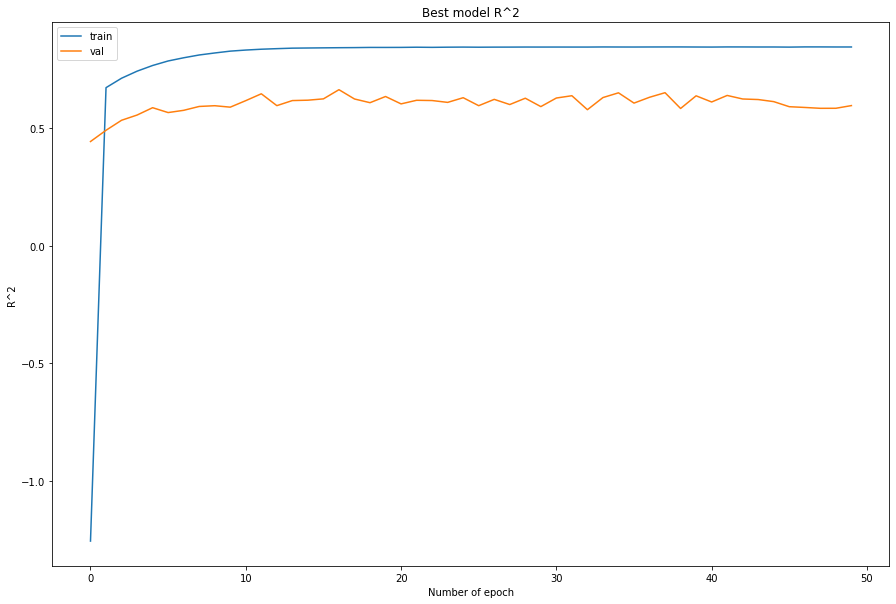

In [30]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q2_best_model_history['best_model'].history['r2'])
plt.plot(Q2_best_model_history['best_model'].history['val_r2'])
plt.title('Best model R^2')
plt.ylabel('R^2')
plt.xlabel('Number of epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Question 2E

In [31]:
# Do a prediction on test set and look for error against predicted - actual


def flatten(l):
    return [item for sublist in l for item in sublist]

def df_to_dataset(dataframe):
    dataframe = dataframe.copy()
    
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

## We use the test dataframe defined in the first question (Test > 2020)
Q2E_test_df = test_dataframe.copy()
Q2E_test_ds = df_to_dataset(Q2E_test_df)
Q2E_test_ds = Q2E_test_ds.batch(256)

# Load the best weights 
Q2_best_model.load_weights('PartB_bestepoch/')

prediction =  Q2_best_model.predict(Q2E_test_ds)
prediction = flatten(prediction)
data_df = test_dataframe.copy()
data_df["Predicted Resale Value"] = prediction

data_df["Error"] = abs(data_df["resale_price"] - data_df["Predicted Resale Value"])
data_df = data_df.sort_values(by="Error", ascending=False)
data_df = data_df.head(30)

data_df

 14/180 [=>............................] - ETA: 0s 

c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 1s 4ms/step


,month,year,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price,Predicted Resale Value,Error
119399,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,40 TO 42,1400000.0,898935.50000,501064.50000
114504,12,2021,0.428356,8.948410,0.016807,0.001358,"EXECUTIVE, Maisonette",66.666667,154.0,04 TO 06,1238000.0,745877.50000,492122.50000
119400,5,2022,0.586629,2.932814,0.016807,0.047782,"5 ROOM, Improved",96.083333,113.0,46 TO 48,1380000.0,901136.87500,478863.12500
127227,8,2022,0.489478,3.977493,0.016807,0.008342,"5 ROOM, Premium Apartment",93.083333,104.0,13 TO 15,1181000.0,704938.06250,476061.93750
120164,1,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.666667,146.0,07 TO 09,1202000.0,739249.18750,462750.81250
121586,4,2022,0.245502,9.313260,0.016807,0.001179,"5 ROOM, Improved",95.333333,112.0,22 TO 24,1188000.0,734951.68750,453048.31250
120166,3,2022,0.271583,9.003026,0.016807,0.001358,"EXECUTIVE, Maisonette",65.500000,146.0,13 TO 15,1198000.0,752621.62500,445378.37500
117107,7,2022,1.216557,8.071776,0.016807,0.006243,"EXECUTIVE, Apartment",72.833333,146.0,04 TO 06,1120000.0,674668.68750,445331.31250
127207,8,2022,0.504800,5.727076,0.016807,0.010276,"5 ROOM, Model A",73.166667,138.0,07 TO 09,1128000.0,683150.81250,444849.18750
127251,8,2022,0.334556,5.561626,0.016807,0.010276,"5 ROOM, Improved",75.333333,124.0,25 TO 27,1200000.0,757169.12500,442830.87500


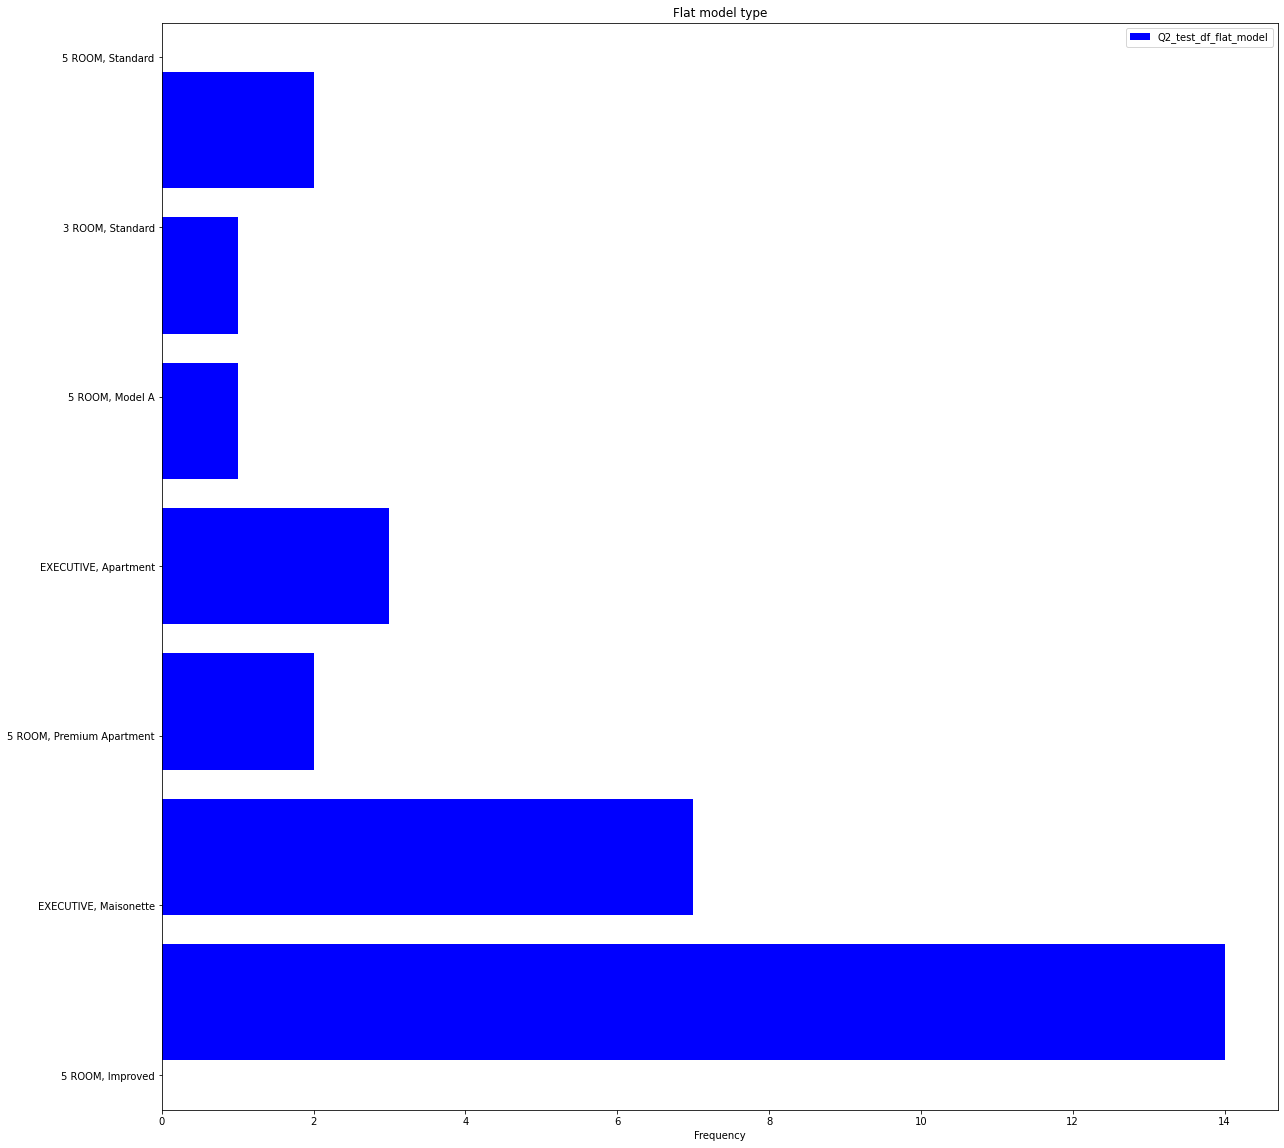

In [32]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist(data_df['flat_model_type'],bins = data_df["flat_model_type"].nunique(), histtype='bar', color =['blue'], label=[ 'Q2_test_df_flat_model'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Flat model type')
axes.set_xlabel('Frequency')
plt.show()

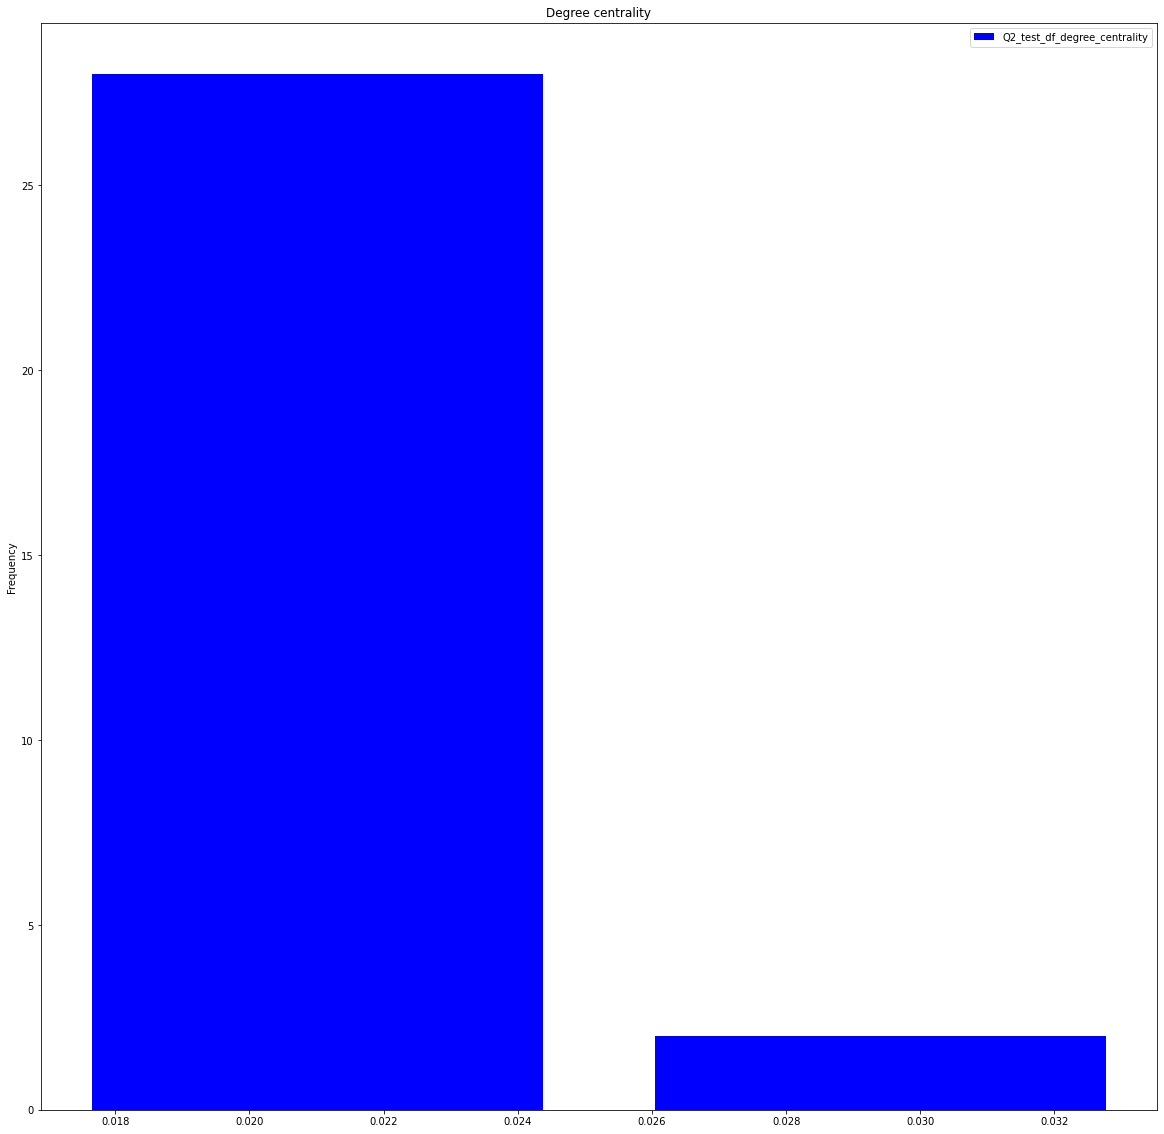

In [33]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist(data_df['degree_centrality'],bins = data_df["degree_centrality"].nunique(), histtype='bar', color =['blue'], label=[ 'Q2_test_df_degree_centrality'],rwidth=0.8)
axes.legend(loc='upper right')
axes.set_title('Degree centrality')
axes.set_ylabel('Frequency')
plt.show()

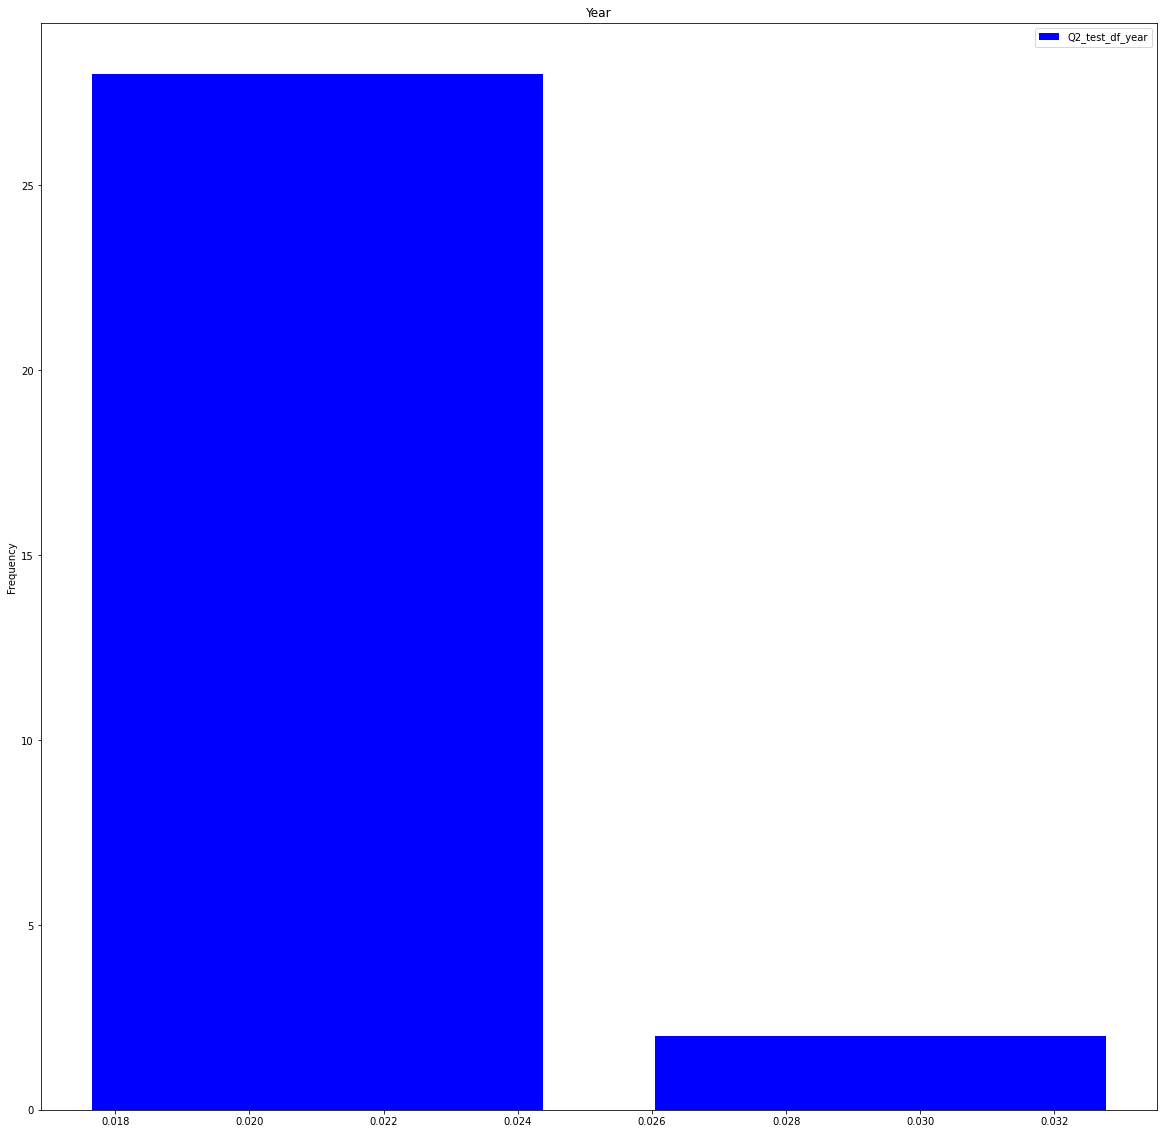

In [34]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist(data_df['degree_centrality'],bins = data_df["year"].nunique(), histtype='bar', color =['blue'], label=[ 'Q2_test_df_year'],rwidth=0.8)
axes.legend(loc='upper right')
axes.set_title('Year')
axes.set_ylabel('Frequency')
plt.show()

#### List down the trends

**Since the best model was train using train_ds, I will be using test_ds for the model's prediciton. From the model's prediction, we can see that the largest error mainly comes from high value HDB apartment (5 room or better). This could be due to sharp rise in prices of 5 room or better HDB apartments over the past few years as compared to the other flat types**. 

**An alternative solution will be to introduce more data into the training dataset which are from the past year(2021) and current year(2022) such that the model have the information to learn about current HDB pricing trends**

## Question 3

In [35]:
# old test set
Q3_old_df = pd.read_csv('hdb_price_prediction_old.csv')

Q3_old_test_df = Q3_old_df[Q3_old_df["year"]>2020].copy()
Q3_old_test_df = Q3_old_test_df.drop(category_not_used, axis = 1)
Q3_old_test_ds = dataframe_to_dataset(Q3_old_test_df)
Q3_old_test_ds = Q3_old_test_ds.batch(128)

# new test set
Q3_new_test_2021_df = test_dataframe[test_dataframe["year"]==2021].copy()
Q3_new_test_2022_df = test_dataframe[test_dataframe["year"]==2022].copy()

Q3_new_test_2021_ds = dataframe_to_dataset(Q3_new_test_2021_df)
Q3_new_test_2022_ds = dataframe_to_dataset(Q3_new_test_2022_df)

Q3_new_test_2021_ds = Q3_new_test_2021_ds.batch(256)
Q3_new_test_2022_ds = Q3_new_test_2022_ds.batch(256)


## Question 3A

In [36]:
old_test_loss, old_test_R2 = Q2_best_model.evaluate(Q3_old_test_ds)
print('Old Test RMSE: %f' % sqrt(old_test_loss))
print('Old Test R^2: %f' % old_test_R2)

new_test_2021_loss, new_test_2021_R2 = Q2_best_model.evaluate(Q3_new_test_2021_ds)
print('Test RMSE_2021: %f' % sqrt(new_test_2021_loss))
print('Test R^2_2021: %f' % (new_test_2021_R2))

new_test_2022_loss, new_test_2022_R2 = Q2_best_model.evaluate(Q3_new_test_2022_ds)
print('Test RMSE_2022: %f' % sqrt(new_test_2022_loss))
print('Test R^2_2022: %f' % (new_test_2022_R2))

#Output in a table

data = {"Old Test RMSE": [sqrt(old_test_loss)],
        "Old Test R^2": [(old_test_R2)],
        "Test RMSE_2021": [sqrt(new_test_2021_loss)],
        "Test R^2_2021": [(new_test_2021_R2)],
        "Test RMSE_2022": [(new_test_2022_loss)],
        "Test R^2_2022": [(new_test_2022_R2)]}

data_df = pd.DataFrame.from_dict(data)
data_df

131/131 [==============================] - 1s 5ms/step - loss: 5510208000.0000 - r2: 0.7854
Old Test RMSE: 74230.775289
Old Test R^2: 0.785375
114/114 [==============================] - 1s 4ms/step - loss: 6455826944.0000 - r2: 0.7538
Test RMSE_2021: 80348.160800
Test R^2_2021: 0.753760
67/67 [==============================] - 0s 4ms/step - loss: 13918139392.0000 - r2: 0.5124
Test RMSE_2022: 117975.164302
Test R^2_2022: 0.512415


,Old Test RMSE,Old Test R^2,Test RMSE_2021,Test R^2_2021,Test RMSE_2022,Test R^2_2022
0,74230.775289,0.785375,80348.1608,0.75376,1.391814e+10,0.512415


## Question 3B 
#### Compare the extent to which model degradation has impacted your model to that of the team's linear regression model and explain why this has occured.

| Linear Regression Model |  R^2 value |            
| --- | --- |
| Q1B Test > 2020 | .627 |
| Q3B Old Test > 2020  | .760 |
| Q3B Test  == 2021  | .715 |
| Q3B Test  == 2022  | .464 |

--**Neural Network Model**--

| NN model |  R^2 value |
| --- | --- |
| Q3B Old Test > 2020  | .742431 |
| Q3B Test  == 2021  | .700047 |
| Q3B Test  == 2022  | .419732 |


**Model degradation has led to a signiifcant drop in R^2 value in the neural network model as compared to the linear regression model. Due to the nature of neural networks, the quality and amount of training dataset is more emphasised than on linear regression models. Hence, neural network is very sensitive to unseen data that has different characteristics to its training dataset. This therefore leads to a poor predictions.** 

## Question 3C

#### Identifying Covariate shift 

In [37]:
# As we used train_ds for best_model, we are going to use train_dataframe

train_df_shift = train_dataframe.copy()
Q3_old_test_df_shift = Q3_old_test_df.copy()
test_df_2021_shift = Q3_new_test_2021_df.copy()
test_df_2022_shift = Q3_new_test_2022_df.copy()

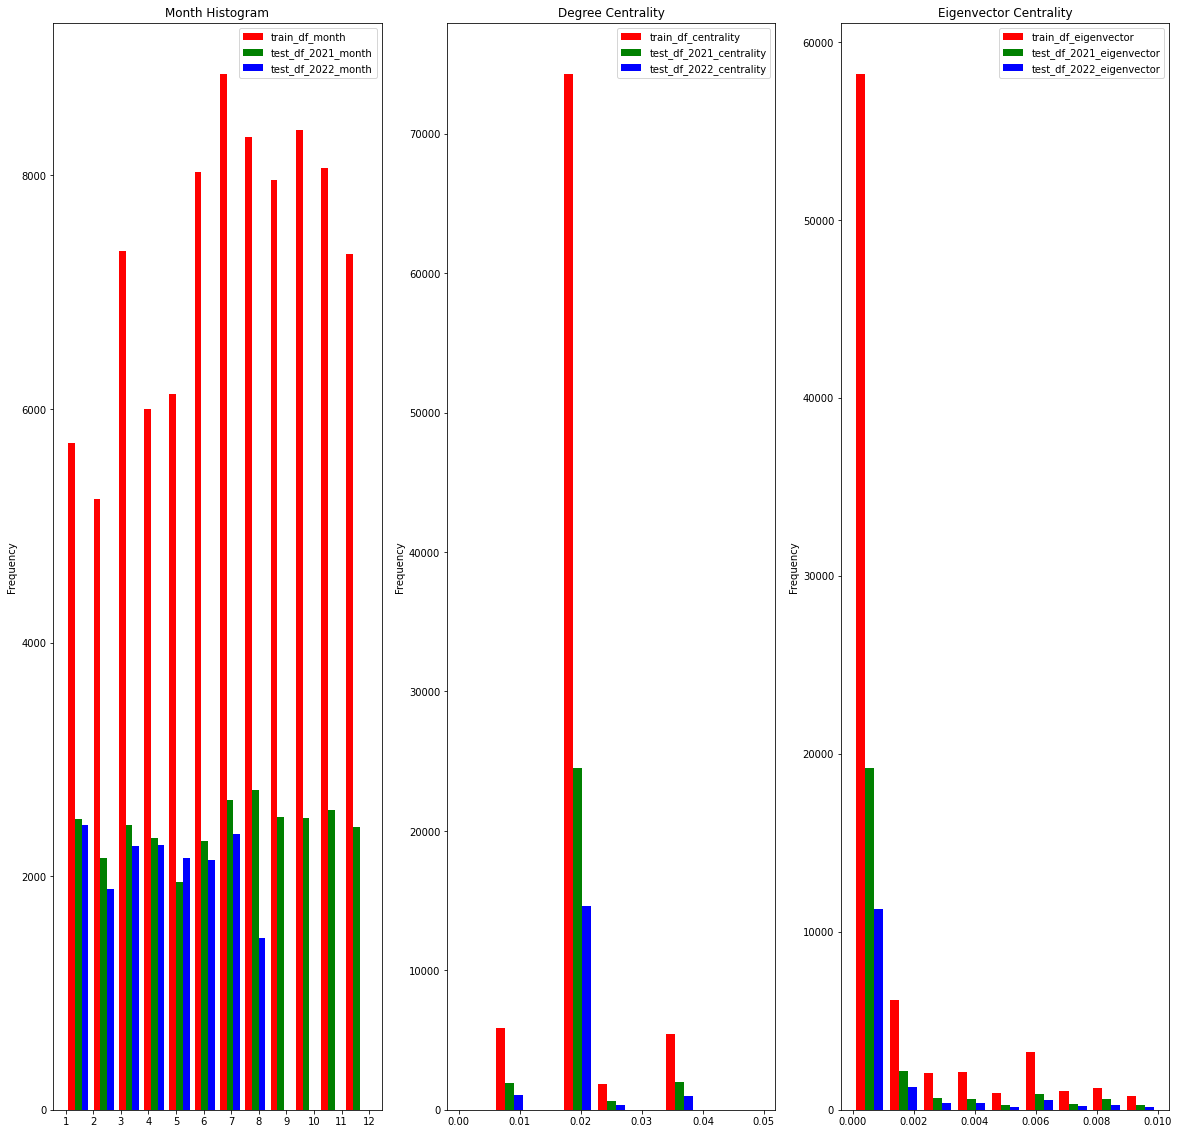

In [38]:
fig, axes =plt.subplots(1,3, figsize=(20,20))
axes[0].hist([train_df_shift["month"], test_df_2021_shift["month"],test_df_2022_shift["month"]],bins = 12, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_month', 'test_df_2021_month', 'test_df_2022_month'],rwidth=0.8)
axes[0].legend(loc='upper right')
axes[0].set_title('Month Histogram')
axes[0].set_xticks(range(1,13))
axes[0].set_ylabel('Frequency')

axes[1].hist([train_df_shift["degree_centrality"], test_df_2021_shift["degree_centrality"],test_df_2022_shift["degree_centrality"]],bins = np.linspace(0, 0.05, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_centrality', 'test_df_2021_centrality', 'test_df_2022_centrality'],rwidth=0.8)
axes[1].legend(loc='upper right')
axes[1].set_title('Degree Centrality')
axes[1].set_ylabel('Frequency')

axes[2].hist([train_df_shift["eigenvector_centrality"], test_df_2021_shift["eigenvector_centrality"],test_df_2022_shift["eigenvector_centrality"]],bins = np.linspace(0, 0.01, num=10), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_eigenvector', 'test_df_2021_eigenvector', 'test_df_2022_eigenvector'],rwidth=0.8)
axes[2].legend(loc='upper right')
axes[2].set_title('Eigenvector Centrality')
axes[2].set_ylabel('Frequency')

plt.show()

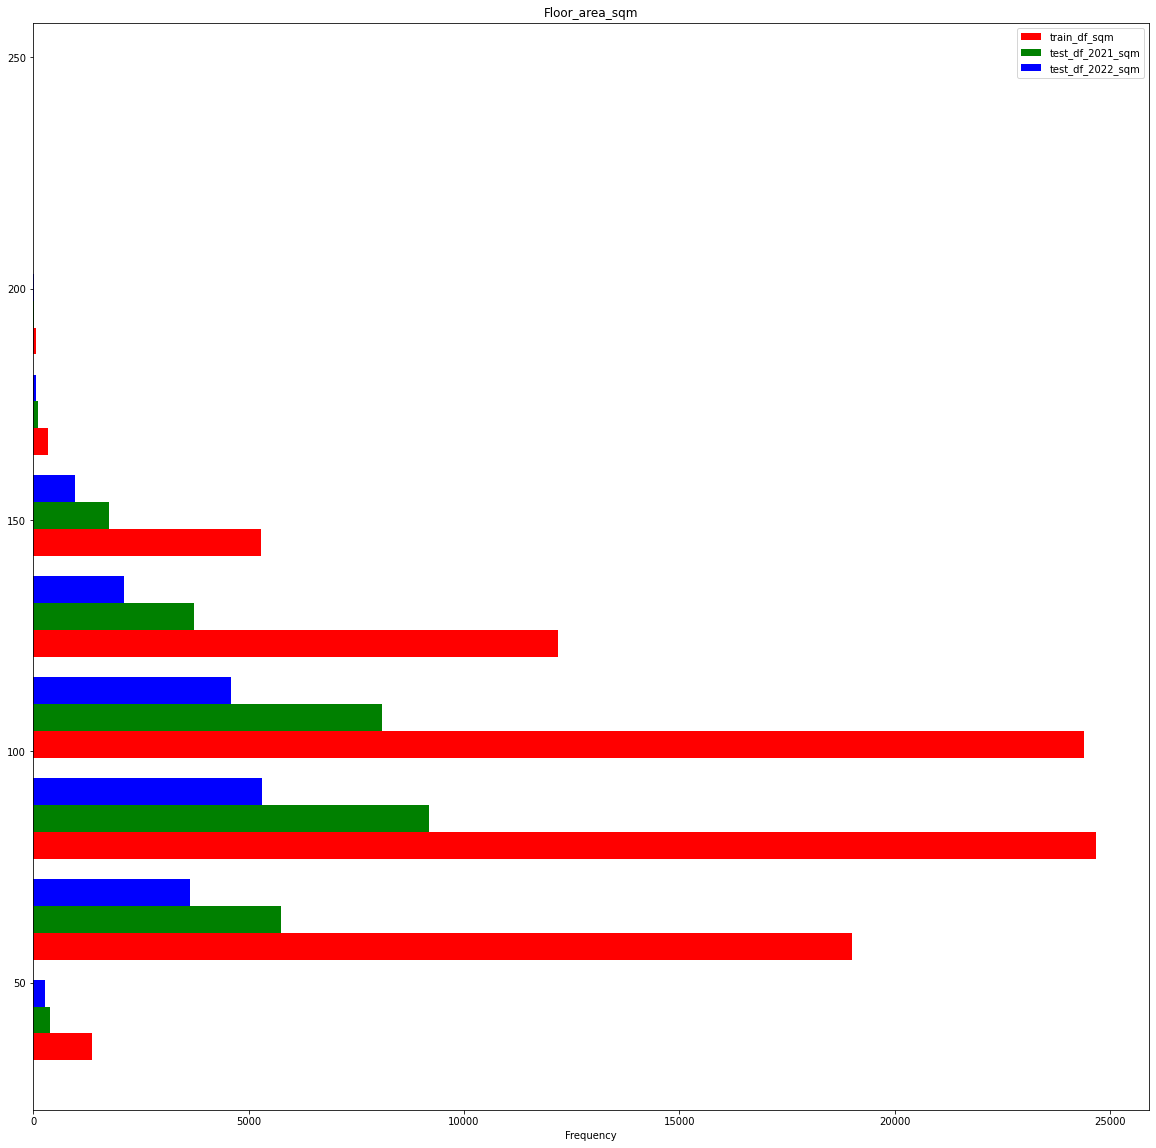

In [39]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["floor_area_sqm"], test_df_2021_shift["floor_area_sqm"],test_df_2022_shift["floor_area_sqm"]],bins = 10 , histtype='bar', color =['red', 'green', 'blue'], label=['train_df_sqm', 'test_df_2021_sqm', 'test_df_2022_sqm'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Floor_area_sqm')
axes.set_xlabel('Frequency')
plt.show()

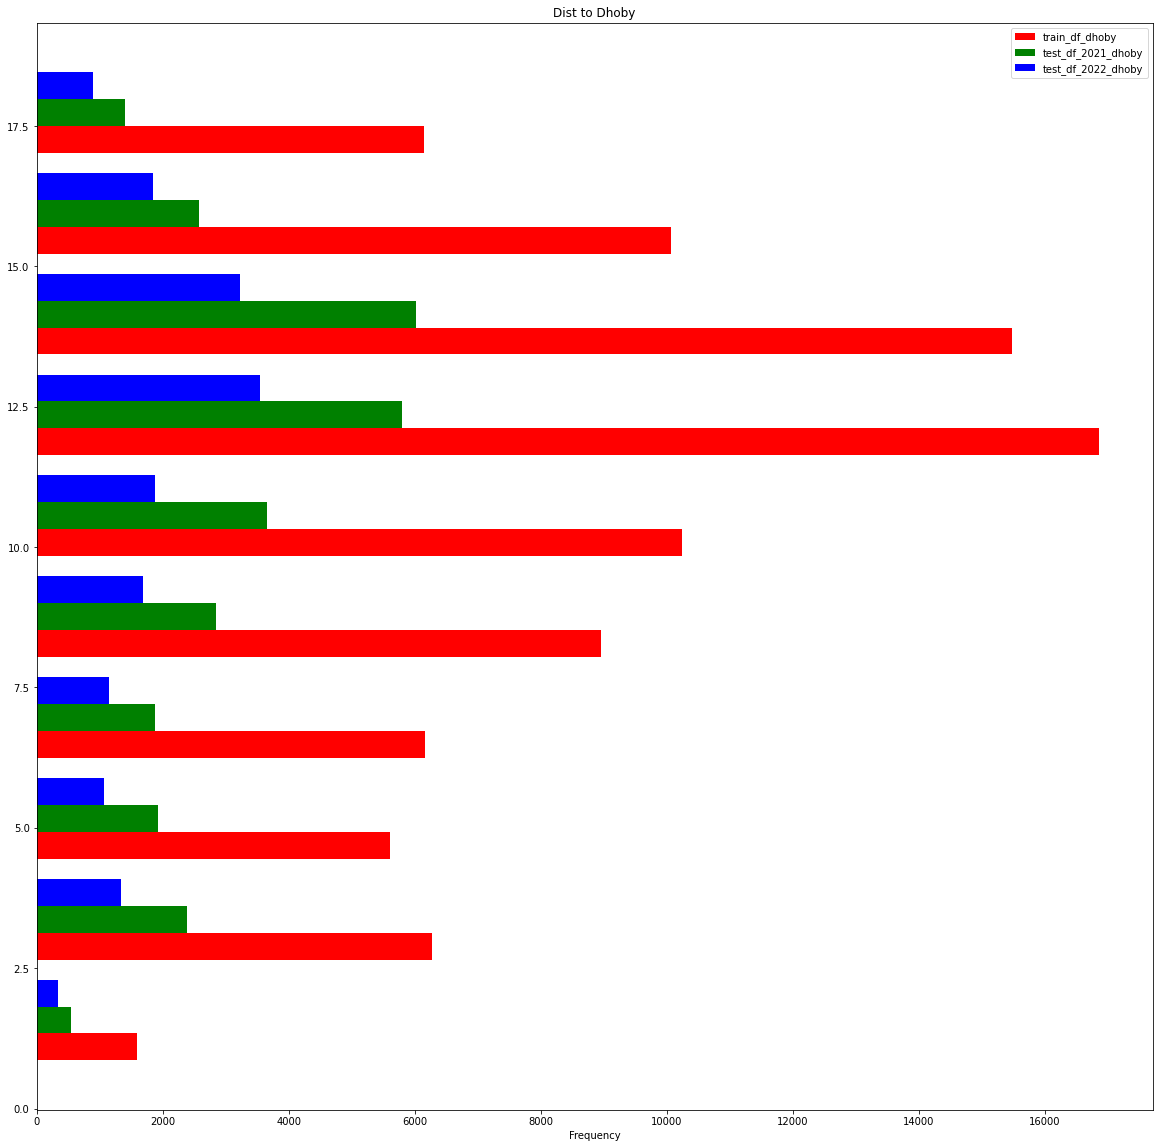

In [40]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["dist_to_dhoby"], test_df_2021_shift["dist_to_dhoby"],test_df_2022_shift["dist_to_dhoby"]],bins = 10, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_dhoby', 'test_df_2021_dhoby', 'test_df_2022_dhoby'],rwidth=0.8,orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Dist to Dhoby')
axes.set_xlabel('Frequency')
plt.show()

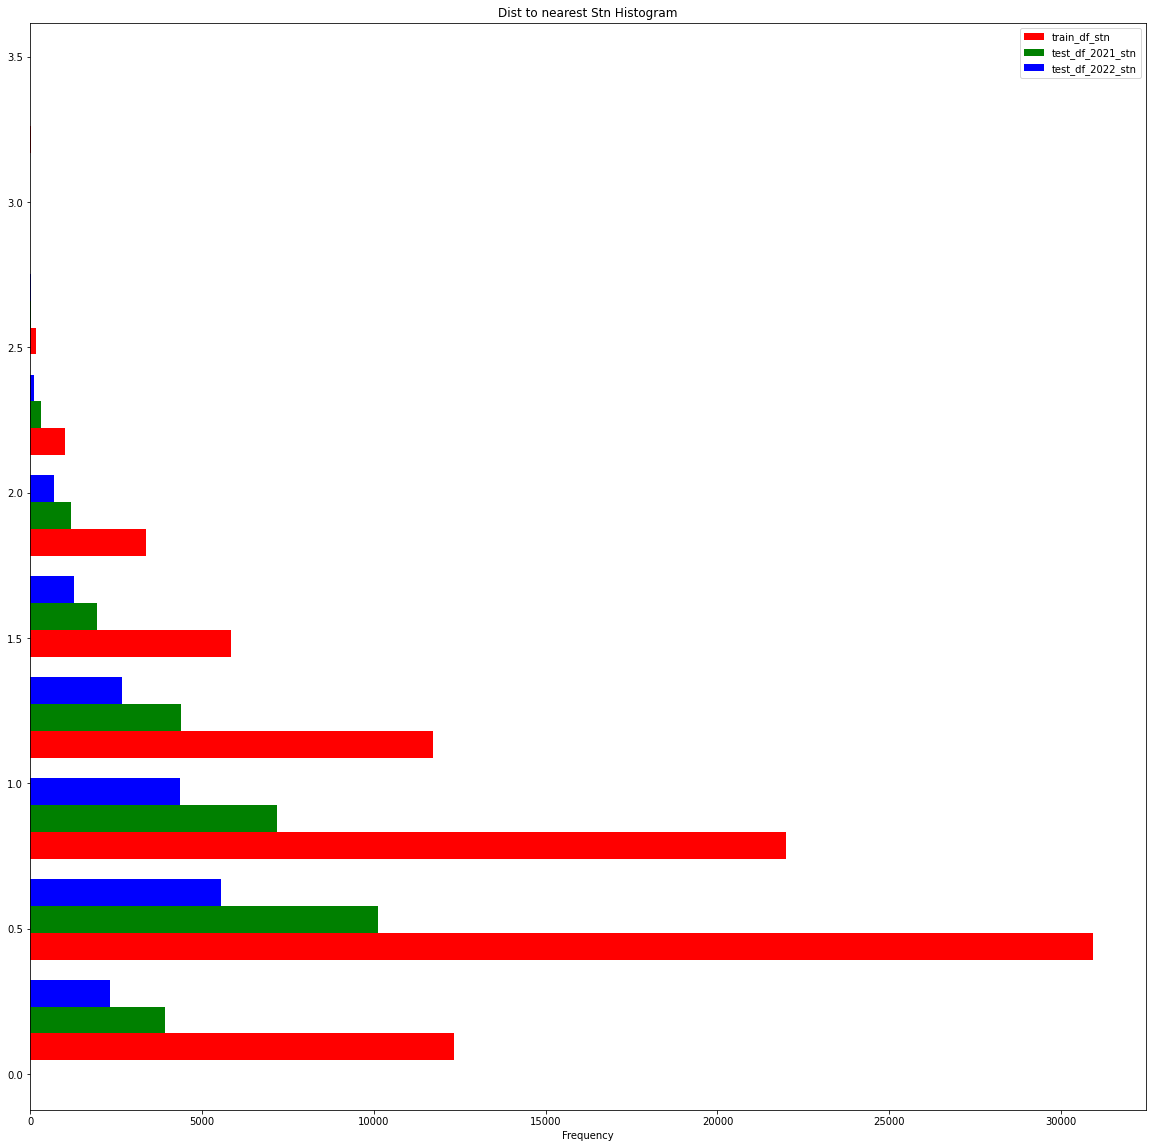

In [41]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["dist_to_nearest_stn"], test_df_2021_shift["dist_to_nearest_stn"],test_df_2022_shift["dist_to_nearest_stn"]],bins = 10, histtype='bar', color =['red', 'green', 'blue'], label=['train_df_stn', 'test_df_2021_stn', 'test_df_2022_stn'], orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Dist to nearest Stn Histogram')
axes.set_xlabel('Frequency')
plt.show()


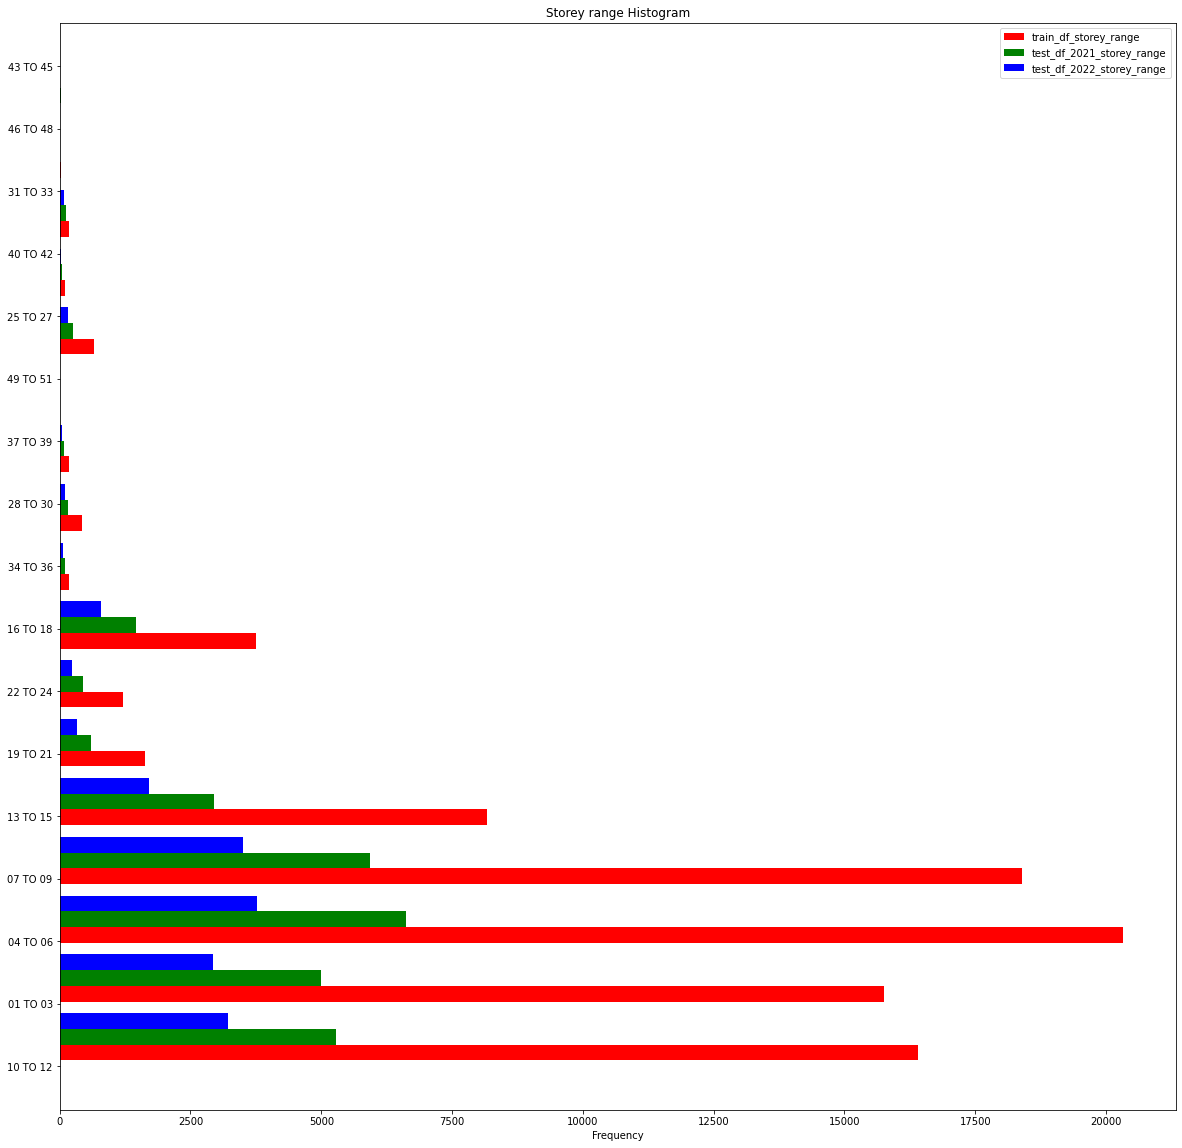

In [42]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["storey_range"], test_df_2021_shift["storey_range"],test_df_2022_shift["storey_range"]],bins = train_df_shift["storey_range"].nunique(), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_storey_range', 'test_df_2021_storey_range', 'test_df_2022_storey_range'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Storey range Histogram')
axes.set_xlabel('Frequency')
plt.show()

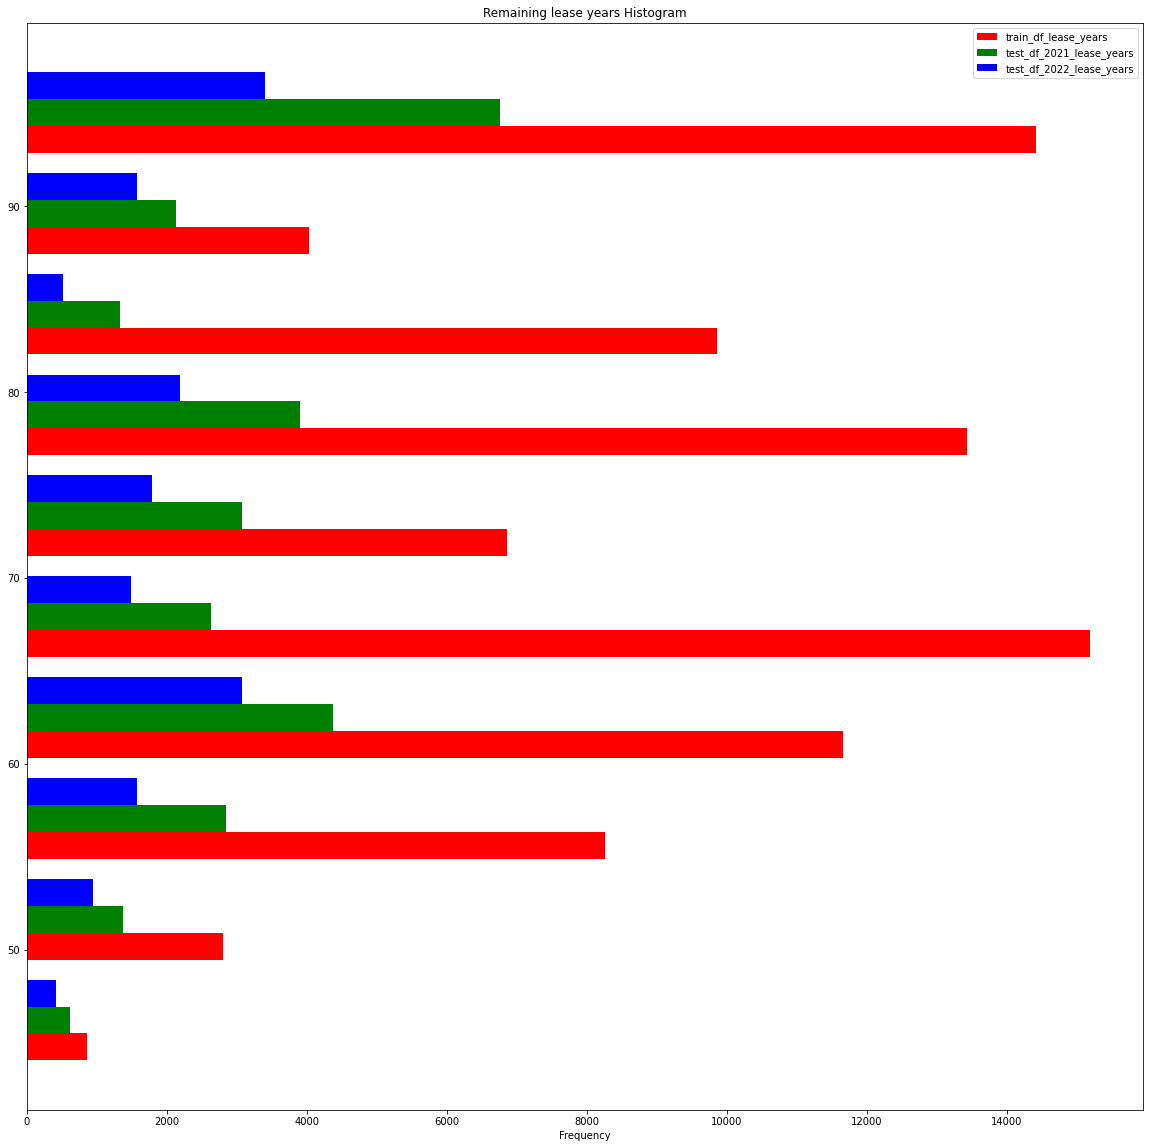

In [43]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["remaining_lease_years"], test_df_2021_shift["remaining_lease_years"],test_df_2022_shift["remaining_lease_years"]],bins =10 , histtype='bar', color =['red', 'green', 'blue'], label=['train_df_lease_years', 'test_df_2021_lease_years', 'test_df_2022_lease_years'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Remaining lease years Histogram')
axes.set_xlabel('Frequency')
plt.show()

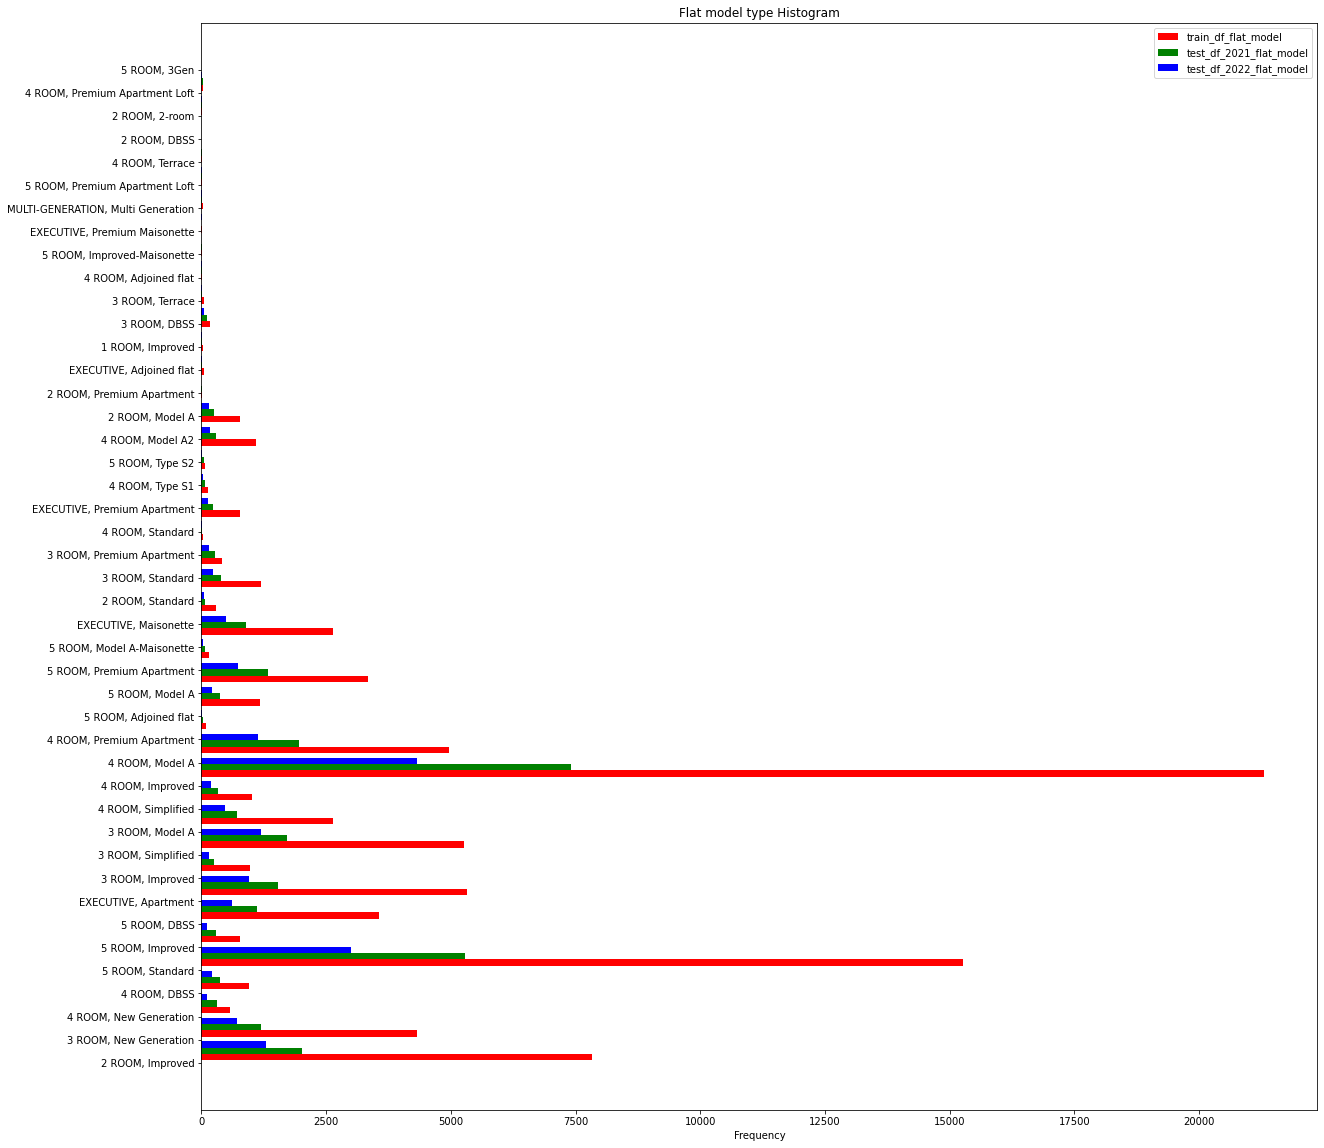

In [44]:
fig, axes =plt.subplots(1, figsize=(20,20))
axes.hist([train_df_shift["flat_model_type"], test_df_2021_shift["flat_model_type"],test_df_2022_shift["flat_model_type"]],bins = test_df_2021_shift["flat_model_type"].nunique(), histtype='bar', color =['red', 'green', 'blue'], label=['train_df_flat_model', 'test_df_2021_flat_model', 'test_df_2022_flat_model'],rwidth=0.8, orientation='horizontal')
axes.legend(loc='upper right')
axes.set_title('Flat model type Histogram')
axes.set_xlabel('Frequency')
plt.show()

## Question 3C 

#### Which variable showed the largest covariate/label shift that might have led to the drop in model performance as seen in 3b? 

**From the histogram plot, the Month has the largest distribution shift within the train and test dataset which could be the reason for the drop in R^2 values**

**The easiest way would be to drop the features which are being classifed as drifiting, however this might result in a loss of information**. **Alternatively, it would be to retrieve more updated dataset and integrate into training**

## Question 3D & 3E

#### RFE.py

In [45]:
"""
Implementation of recursive feature elimination algorithm for neural networks.

Recursive feature elimination (RFE) is a feature selection method that removes unnecessary features from the inputs. 
It can also shed some insights on how much each feature contributes to the prediction task.

The algorithm starts by removing one input feature whose removal leads to the minimum drop (or maximum improvement) in performance. 
- Given k features, to determine which of the k features will cause the minimum drop / maximum increase when that feature is removed, you will have to perform k experiments. After removing that feature, k-1 features will be left and you will have to perform k-1 experiments to determine the next feature to remove.
    - In the case removing a feature leads to an improvement from the baseline (all features used), that feature is likely not useful since removing it actually helped the model to perform better.
    - There will also be cases when all subsets with k-1 features do not do better than the baseline model. In that case, it is likely that all features are useful. You can get a sense of which are more useful than others by looking at the increase in error that occurs when the feature is removed.

This procedure is repeated recursively on the reduced input set until the optimal number of input features is reached. 
- The feature removal goes on until either 1 feature is left, or the model performance does not improve from the previous best (e.g. when there are 7 features left, if none of the 7 experiments performed does better than the best performance of the model with 8 features, the RFE algorithm terminates).
- The condition to stop the recursive process once all (k-1)-features models do worse than the best k-features model was added to make the algorithm terminate earlier so that you don't have to run too many iterations. Also, if the condition happens, then subsequent search is likely to be fruitless (it's always possible for the contrary to happen, but the chances are low and it's usually not worth the additional time).

Each model should use a different subset of features and they are trained independently. There is no loading of weights from any previous models.


In the code below, a boolean mask `vec` is used to keep track of which features to select during the iteration. 

You need to place your model training code into the 'train_model' function and have it return the validation loss.

Look out for the comments labelled 'TODO'.

"""

import time
start = time.time()

num_features = 9

vec = [1 for i in range(num_features)]
best_loss = 1e15
new_best_loss = 1e14
which_iter = ''

all_losses = [] # should be len 9,8,7,...


def train_model(feature_mask):
    """
    Given a boolean mask (feature_mask), select the features accordingly, train the model and return the validation loss.
    """
    
    feature_mask_string = ''.join([str(i) for i in feature_mask])

    # TODO: define the input layer here (your code from Q2)

    divisor = hp.Int("divisor", min_value=1, max_value=2, step=1)
    hidden_units = hp.Int("hidden_units", min_value=4, max_value=32, step=4)
    Q2_optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 2e-1, sampling='log'))
    
    month_num_categories = df["month"].nunique()
    flat_model_type_num_categories = df["flat_model_type"].nunique()
    storey_range_num_categories = df["storey_range"].nunique()


    #Integer categorical features
    month_embedded = Q2_encode_categorical_feature(month, "month",train_ds, False, month_num_categories, divisor)
    #String categorical features
    flat_model_type_embedded = Q2_encode_categorical_feature(flat_model_type, "flat_model_type",train_ds, True, flat_model_type_num_categories, divisor)
    storey_range_embedded = Q2_encode_categorical_feature(storey_range, "storey_range",train_ds, True, storey_range_num_categories, divisor)
    
    #Numerical features
    dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
    dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)
    degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
    eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
    remaining_lease_year_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
    floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm,"floor_area_sqm", train_ds)
    
    all_features_input = [
                        month_embedded,
                        storey_range_embedded,
                        flat_model_type_embedded,
                        floor_area_sqm_encoded,
                        remaining_lease_year_encoded,
                        degree_centrality_encoded,
                        eigenvector_centrality_encoded,
                        dist_to_nearest_stn_encoded,
                        dist_to_dhoby_encoded
                    ]
            
    selected_inputs = []
    print('going through feature_mask', feature_mask)
    for i,j in zip(all_features_input, feature_mask):
        if j == 1:
            selected_inputs.append(i)
            print(i)
        else:
            print('Skipping', i)

    all_features = layers.concatenate(selected_inputs)
    
    
    # TODO: Complete the rest of the architecture + training code and retrieve the training history
    Q2D_model_history = {}
    hidden_layer = layers.Dense(units=hidden_units, activation ="linear")(all_features)
    output = layers.Dense(1, activation="linear")(hidden_layer)
    Q2D_model = keras.Model(all_inputs, output)
    Q2D_model.compile(optimizer=Q2_optimizer, loss= "mse",metrics=[r2])
    
    # Train on the non-test split ( 2020 and before hence using train_ds instead of Q2_train_ds)
    # Use callback for this
    Q2D_model_history["model"] = Q2D_model.fit(train_ds, epochs=50, validation_data = test_ds, verbose=1, callbacks=callback)
    
    
    val_loss_hx = square_roots(Q2D_model_history["model"].history["val_loss"]) # NOTE: You can use RMSE if you find it easier to interpret.
    val_loss_min = min(val_loss_hx)
    
    return val_loss_min


## RFE starts here 

while sum(vec) > 0 and best_loss > new_best_loss:
    
    print('vec', vec)

    best_loss = new_best_loss
    new_min_loss_flag = False
    
    losses_from_same_vec = []
    
    for ix, i in enumerate(vec):
        
        print('ix', ix, 'i', i)
        
        if i == 0:
            continue # if the feature is off, no need to do anything, go to next position
        else:
            temp_vec = vec[:]
            temp_vec[ix] = 0 # turn off the feature
            print('updated temp_vec', temp_vec)
            
            loss = train_model(temp_vec)
            losses_from_same_vec.append(loss)
            
            if loss < new_best_loss:
                new_best_loss = loss
                which_iter = 'len ' + str(sum(vec)) + ', ix ' + str(ix)
                print('new min loss:', which_iter)
                new_min_loss_flag = True
                min_loss_vec = temp_vec[:]

            tf.keras.backend.clear_session()
            print('session cleared!\n')
                
    
    all_losses.append(losses_from_same_vec)
    
    # After going through the vec once, update vec if new min loss    
    if new_min_loss_flag:
        vec = min_loss_vec
    
    # else case means no new min loss, the latter while loop condition will cause it to terminate 
    print(time.time() - start, 'seconds elapsed')
    print()

print(all_losses)


vec [1, 1, 1, 1, 1, 1, 1, 1, 1]
ix 0 i 1
updated temp_vec [0, 1, 1, 1, 1, 1, 1, 1, 1]


NameError: name 'hp' is not defined

In [ ]:
best_feature_subset = []
input = [
                    "month",
                    "storey_range",
                    "flat_model_type",
                    "floor_area_sqm",
                    "remaining_lease_year",
                    "degree_centrality",
                    "eigenvector_centrality",
                    "dist_to_nearest_stn",
                    "dist_to_dhoby"
                    ]

for i in range(len(vec)):
    if vec[i] == 1:
        best_feature_subset.append(input[i])

print(best_feature_subset)
        

['month', 'storey_range', 'flat_model_type', 'floor_area_sqm', 'remaining_lease_year', 'degree_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby']


**Best feature subset is month, storey_range, flat_model_type, floor_area_sqm, remaining_lease_year, degree_centrality, dist_to_nearest_stn and dist_to_dhoby**

#### Discuss if there is any concept shift compared to RFE on 'old_test_set'

**Yes, the old test set contains information only up till Aug 2021 while the test set has updated information up till Aug 2022. In 2021, Singapore is still in the midst of the pandemic where there was a series of safe distancing measurements between introduce during the period. Thus, people's livelihood was affected and not many people could afford buying a resale HDB flat or making a large buying price 

## CONCLUSION

#### Question 2

##### 1. Bayesian and Hyperband optimization

**Bayesian Optimization builds a probability model of the objective function and uses it to select hyperparameters to evaluate in the true objective function.**

**Hyperband is essentially just a grid search over the optimal allocation strategy. So at each individual trial the set of hyperparameters is chosen randomly. Hyperband is the extension of the Successive Halving algorithm** 

**Random search tests hyperparameter sets at random, hence it runs the risk of missing the ideal set of hyperparameters and forgoing peak model performance. However, with Bayesian optimization method,the user do not have to incorporate randomness and risk missing the optimal solution. Although, Bayesian optimization does has its drawbacks as additional time is required to determine the next hyperparameters to evaluate based on the results of the previous iterations.**

##### 2. Random search vs Grid search

**Depending on the size of the hyperparameter search space and use case, the benefits of using grid search against random search varies.** 

**Using the brute force grid search method is simple and straightforward but an increase in the size of hyperparameter search space will result in an exponential rise in run time and computation.**

**Random search method would reduce the computation time significantly but user might run the risk of missing the optimal case**




#### Question 3

**Concept shift may have been the lead cause of model degradation, due to the pandemic, rising tensions between superpowers and high inflation rate, the consumers' behaviours has changed significantly over the past few years.**

**Since the model is trained on past data, the model do not have the information on the current economical factors that have led to changes in housing prices**